# Data Management

## Create a project folder

Here is a recommended folder structure for your fMRI project. 

```bash
# ======================================================================
# Recommended study directory structure
# ======================================================================

# project_name                     
#    └── code
#        └── analysis             # analysis code 
#        └── preprocessing        # this is where heudiconv, fmriprep, mriqc scripts go
#        └── task                 # experimental task code can go here
#    └── data                     # this is where BIDS data and its derivatives will be saved
#    └── doc                      # manuscript, notebooks 
#    └── results                  # analysis results
#    └── work                     # where intermediate results should be stored

```

You can create it manually or use a simple `command line` command: 
```bash
mkdir -p My_fMRI_study/{code/{analysis,preprocessing,task},data,doc,results,work}
```

## Version control

To initiate your analysis version control, you'd type the following in the terminal:
```bash
cd My_fMRI_study
git init
```

You don't need to track everything in your project. Mainly, you'd like to track your analysis scripts, and perhaps your documents. Basically, everything that is **'text based'**. To exclude certain directories from being tracked, you can create a `.gitignore` file and specify there what to exclude from tracking. 

For example a `.gitignore` file with content showh below, will exclude `data`, `results`, and `work` directories from version control tracking. 

```bash
data
results
work
```

For basic `git` commands, see, for example, this [Git Cheat Sheet](https://about.gitlab.com/images/press/git-cheat-sheet.pdf)

## Retrieving the DICOM files

`DICOM` files are the raw imaging files that come from the MRI scanner. Usually they are stored on some MRI data server. At the CBU, each imaging project has a unique code. Knowing my project's code, I can locate the raw `DICOM` files on our server.


In [1]:
ls -d /mridata/cbu/*_MR09029/*

/mridata/cbu/CBU090817_MR09029/20090803_083228/
/mridata/cbu/CBU090924_MR09029/20090824_095047/
/mridata/cbu/CBU090928_MR09029/20090824_164906/
/mridata/cbu/CBU090931_MR09029/20090825_095125/
/mridata/cbu/CBU090935_MR09029/20090825_164313/
/mridata/cbu/CBU090938_MR09029/20090826_094337/
/mridata/cbu/CBU090942_MR09029/20090826_164150/
/mridata/cbu/CBU090945_MR09029/20090827_093537/
/mridata/cbu/CBU090951_MR09029/20090828_093853/
/mridata/cbu/CBU090954_MR09029/20090828_163356/
/mridata/cbu/CBU090956_MR09029/20090901_095651/
/mridata/cbu/CBU090957_MR09029/20090901_115356/
/mridata/cbu/CBU090958_MR09029/20090901_133852/
/mridata/cbu/CBU090960_MR09029/20090901_165638/
/mridata/cbu/CBU090962_MR09029/20090902_100102/
/mridata/cbu/CBU090964_MR09029/20090902_135553/
/mridata/cbu/CBU090966_MR09029/20090902_171511/
/mridata/cbu/CBU090967_MR09029/20090904_095737/
/mridata/cbu/CBU090968_MR09029/20090904_135928/
/mridata/cbu/CBU090970_MR09029/20090904_172442/
/mridata/cbu/CBU091410_MR09029/20091210_

## Brain Imaging Data Structure (BIDS)

***!For a more detailed tutorial see: [https://imaging.mrc-cbu.cam.ac.uk/imaging/dicom-bids](https://imaging.mrc-cbu.cam.ac.uk/imaging/dicom-bids).***

To proceed with analysis, we need to convert the `DICOMs` to `NIfTI` format and then organise all these files in a 'nice' way.

[Brain Imaging Data Structure (**BIDS**)](https://bids-specification.readthedocs.io/en/stable/) is a a standard for organizing and describing neuroimaging (and behavioural) datasets. See [BIDS paper](https://doi.org/10.1038/sdata.2016.44) and http://bids.neuroimaging.io website for more information.

How to get your DICOMs into NIfTI and into BIDS?

Several tools exist (see a full list [here](https://bids.neuroimaging.io/benefits#converters)). I will here demonstrate a `Python`-based converter [HeuDiConv](https://heudiconv.readthedocs.io/en/latest/index.html). 

`heudiconv` is a flexible `DICOM` converter for organizing brain imaging data into structured directory layouts.
* It allows flexible directory layouts and naming schemes through customizable heuristics implementations
* It only converts the necessary DICOMs, not everything in a directory
* You can keep links to DICOM files in the participant layout
* Using `dcm2niix` under the hood, it’s fast
* It provides assistance in converting to `BIDS`.


### HeuDiConv

To use HeuDiConv, either install heudiconv and dcm2niix packages locally: 
```
pip install heudiconv==0.13.1
conda install -c conda-forge dcm2niix
```

or use Docker (or Apptainer/Singularity) container image
```
docker pull nipy/heudiconv
```

`heidiconv` involves 3 main steps:
1. Discovering what DICOM series (scans) there are in your data
2. Creating a heuristic file specifying how to translate the DICOMs into BIDS
3. Converting the data 

#### Step 1: Discovering your scans

First, you need to know what scans there are and how to uniquely identify them by their metadata. You could look in each scan's DICOM file metadata manually yourself, but that's not very convenient. Instead, you can 'ask' HeuDiConv to do the scan discovery for you. If you run HeuDiConv without NIfTI conversion and heuristic, it will generate a DICOM info table with all scans and their metadata. Like this: 

<img align="left" padding = "16px;" src="https://imaging.mrc-cbu.cam.ac.uk/imaging/dicom-bids?action=AttachFile&do=get&target=dicom_info.png">
<br clear="left"/>

The column names are metadata fields and rows contain their corresponding values.

**Example script:**
To get such a table, you'd write a simple bash script, like this: [code/step01_dicom_discover.sh](https://github.com/dcdace/fMRI_training/blob/main/code/step01_dicom_discover.sh) script

```bash
#!/bin/bash

# ------------------------------------------------------------
# Define your paths
# ------------------------------------------------------------
# Your project's root directory
PROJECT_PATH='/imaging/correia/da05/workshops/2024-CBU'
# Path to the raw DICOM files
DICOM_PATH='/mridata/cbu/CBU090942_MR09029'
# Location of the output data (it will be created if it doesn't exist)
OUTPUT_PATH="${PROJECT_PATH}/work/dicom_discovery/"
# Subject ID
SUBJECT_ID='01'

# ------------------------------------------------------------
# Run the heudiconv
# ------------------------------------------------------------
conda activate fmri

heudiconv \
    --files "${DICOM_PATH}"/*/*/*.dcm \
    --outdir "${OUTPUT_PATH}" \
    --heuristic convertall \
    --subjects "${SUBJECT_ID}" \
    --converter none \
    --bids \
    --overwrite

conda deactivate
# ------------------------------------------------------------

# HeudiConv parameters:
# --files: Files or directories containing files to process
# --outdir: Output directory
# --heuristic: Name of a known heuristic or path to the Python script containing heuristic
# --subjects: Subject ID
# --converter : dicom to nii converter (dcm2niix or none)
# --bids: Flag for output into BIDS structure
# --overwrite: Flag to overwrite existing files
# 
# For a full list of parameters, see: https://heudiconv.readthedocs.io/en/latest/usage.html 

```

After running the script, the table that we are interested in will be located at `OUTPUT_PATH/.heudiconv/[subject ID]/info/dicominfo.tsv``. The .heudiconv directory is a hidden directory and you might not be able to see it in your file system. If so, either enable to view hidden files, or copy the dicominfo.tsv to some other location. For example, your home Desktop:

```bash
cp /imaging/correia/da05/wiki/BIDS_conversion/MRI/work/dicom_discovery/.heudiconv/01/info/dicominfo.tsv ~/Desktop
```
Now, you can open the file, for example, in MS Excel and keep it open for the next step - creating a heuristic file. 

#### Step 2: Creating a heuristic file

The `heuristic` file is used to convert and organize the DICOM data into BIDS standard. You will need to define heuristic keys. Keys define type of scan. 

The key definitions must strictly follow BIDS standart! https://bids-specification.readthedocs.io/en/stable/02-common-principles.html

In our example dataset, we have four types of scans: anatomical image, fieldmaps (magnitude and phase), and functional runs. We will need to define the keys for them all. Like this:

```python
    anat = create_key(
        'sub-{subject}/anat/sub-{subject}_T1w'
        )
    fmap_mag = create_key(
        'sub-{subject}/fmap/sub-{subject}_acq-func_magnitude'
        )
    fmap_phase = create_key(
        'sub-{subject}/fmap/sub-{subject}_acq-func_phasediff'
        )
    func_task = create_key(
        'sub-{subject}/func/sub-{subject}_task-facerecognition_run-{item:02d}_bold'
        )
```

Next, we will need to specify unique criteria that only the particular scan will meet. This information we get from the `dicominfo.tsv` file that we 'discovered' in the previous step. For example, to uniquely identify the anatomical scan, we can specify that the `protocol_name` contains `MPRAGE`. We don't have any other scans with MPRAGE in protocol name, therefore for the anatomical scan, we don't need to specify any additional cireteria. Similarly, we would specify unique identifiers for the other three scans. 

Then we integrate the keys and specifications into a heuristic Python file.

**Example heuristic file**: [code/bids_heuristic.py](https://github.com/dcdace/fMRI_training/blob/main/code/bids_heuristic.py)



```python

def create_key(template, outtype=('nii.gz',), annotation_classes=None):
    if template is None or not template:
        raise ValueError('Template must be a valid format string')
    return template, outtype, annotation_classes

def infotodict(seqinfo):
    
    # Define the keys (file names)
    anat = create_key(
        'sub-{subject}/anat/sub-{subject}_T1w'
        )
    fmap_mag = create_key(
        'sub-{subject}/fmap/sub-{subject}_acq-func_magnitude'
        )
    fmap_phase = create_key(
        'sub-{subject}/fmap/sub-{subject}_acq-func_phasediff'
        )
    func_task = create_key(
        'sub-{subject}/func/sub-{subject}_task-facerecognition_run-{item:02d}_bold'
        )
    
    # Create the dictionary that will be returned by this function.
    info = {
        anat: [], 
        fmap_mag: [], 
        fmap_phase: [],  
        func_task: []
        }

    # Loop through all the DICOM series and assign them to the appropriate conversion key.
    for s in seqinfo:
        # Uniquelly identify each series
        
        # Structural
        if "MPRAGE" in s.protocol_name:
            info[anat].append(s.series_id)
            
        # Field map Magnitude (the fieldmap with the largest dim3 is the magnitude, the other is the phase)
        if (s.dim3 == 66) and ('FieldMapping' in s.protocol_name):
            info[fmap_mag].append(s.series_id)
            
        # Field map PhaseDiff
        if (s.dim3 == 33) and ('FieldMapping' in s.protocol_name):
            info[fmap_phase].append(s.series_id)

        # Functional Bold
        if s.dim4 > 100:
           info[func_task].append(s.series_id)
            
    # Return the dictionary
    return info

# --------------------------------------------------------------------------------------
# Dictionary to specify options to populate the 'IntendedFor' field of the fmap jsons.
# --------------------------------------------------------------------------------------
POPULATE_INTENDED_FOR_OPTS = {
    'matching_parameters': ['ModalityAcquisitionLabel'],
    'criterion': 'Closest'
}
```

#### Step 3: Converting the data

##### Conversting a single-subject

To convert a single subject, we only need to change 2 things in our previous 'DICOM discovery' script:
* the output to be in PROJECT_PATH/data/, 
* location to the heuristic file that we created in the previous step, and 
* we specify the DICOM to NIfTI converter (*dcm2niix*), so that the files are actually converted. 

```bash
# ------------------------------------------------------------
# Define your paths
# ------------------------------------------------------------
# Your project's root directory
PROJECT_PATH='/imaging/correia/da05/workshops/2024-CBU'
# Path to the raw DICOM files
DICOM_PATH='/mridata/cbu/CBU090942_MR09029'
# Location of the output data (it will be created if it doesn't exist)
OUTPUT_PATH="${PROJECT_PATH}/data/"
# Subject ID
SUBJECT_ID='01'

# ------------------------------------------------------------
# Run the heudiconv
# ------------------------------------------------------------
conda activate fmri

heudiconv \
    --files "${DICOM_PATH}"/*/*/*.dcm \
    --outdir "${OUTPUT_PATH}" \
    --heuristic $PROJECT_PATH/code/bids_heuristic.py \
    --subjects "${SUBJECT_ID}" \
    --converter dcm2niix \
    --bids \
    --overwrite

conda deactivate
# ------------------------------------------------------------
```
To convert other subjects as well, you'd need to change the raw DICOM path and subject ID accordingly. If you have multiple subjects, it's a good idea to process them all together using the scheduling system like SLURM (Simple Linux Utility for Resource Management).

##### Converting multiple subjects in parallel using SLURM

First, we need a generic script that runs HeuDiConv. It would be very similar to the one above where we converted a single subject. 

**Example of a generic heudiconv script**: [code/heudiconv_script.sh](https://github.com/dcdace/fMRI_training/blob/main/code/heudiconv_script.sh)

Second, you'd need a project-specific script where you define the paths and use the `sbatch` command to execute the generic script for each subject. You can either write your script in bash, or Python if you prefer a more 'user-friendly' syntax. I have written an example script in Python. 

**Example script to convert multiple subjects' DICOMs to BIDS**: [code/step02_dicom_to_bids.py](https://github.com/dcdace/fMRI_training/blob/main/code/step02_dicom_to_bids.py
)
The script's main function is to generate a list of subject IDs alongside their corresponding DICOM paths, define the heuristic file's location, specify the output path, and then construct and execute an `sbatch`` command to run the *heudiconv_script.sh*. 

### 'To Do' - additional information to check and add

Once you have converted the DICOMs to BIDS, there are some things that you need to fill in yourself to make the dataset fully BIDS compliant. HeuDiConv has marked such 'missing' information as 'To Do'. 

#### Dataset description

`dataset_description.json`

A brief description of your dataset. 

```json
{
  "Acknowledgements": "TODO: whom you want to acknowledge",
  "Authors": [
    "TODO:",
    "First1 Last1",
    "First2 Last2",
    "..."
  ],
  "BIDSVersion": "1.8.0",
  "DatasetDOI": "TODO: eventually a DOI for the dataset",
  "Funding": [
    "TODO",
    "GRANT #1",
    "GRANT #2"
  ],
  "HowToAcknowledge": "TODO: describe how to acknowledge -- either cite a corresponding paper, or just in acknowledgement section",
  "License": "TODO: choose a license, e.g. PDDL (http://opendatacommons.org/licenses/pddl/)",
  "Name": "TODO: name of the dataset",
  "ReferencesAndLinks": [
    "TODO",
    "List of papers or websites"
  ]
}
```

#### Participants

`participants.json`

```json
{
  "participant_id": {
    "Description": "Participant identifier"
  },
  "age": {
    "Description": "Age in years (TODO - verify) as in the initial session, might not be correct for other sessions"
  },
  "sex": {
    "Description": "self-rated by participant, M for male/F for female (TODO: verify)"
  },
  "group": {
    "Description": "(TODO: adjust - by default everyone is in control group)"
  }
}
```

#### Task information

`task-facerecognition_bold.json`

Could add full task name and a Cognitive Atlas ID if it exists. 
```json
{
 ...
  "TaskName": "TODO: full task name for facerecognition",
 ...
 ```

#### Events

For the functional images, if they are not resting-state images, but participants performed a task, you need to provide the trial type, onset and duration details. HeuDiConv generates the `events.tsv` file for each functional run. The files are just a template that you need to fill with the actual data. You would get this data from tour experimental script outputs (make sure you have programmed your task to easily retrieve the needed trial and timing details). 

For the example dataset used in this tutorial, I retrieved the event timing information from the [OpenNeuro version of this dataset](https://openneuro.org/datasets/ds000117/versions/1.0.5)

**See my script here:** [code/step03_events_to_bids.py](https://github.com/dcdace/fMRI_training/blob/main/code/step03_events_to_bids.py)).

The event files in the OpenNeuro version of this dataset, do not fully comply with the current BIDS specification. According to `BIDS` specification for [Task Events](https://bids-specification.readthedocs.io/en/stable/04-modality-specific-files/05-task-events.html), a correct column name is *'trial_type'*, not *'stim_type'*. In my script, after downloading the files, I fixed this naming. In addition, I removed the no-name trial types (the 'rest' period) as we don't want to model rest as a separate event.


This is how an example events file looked generated by HeuDiConv:

In [2]:
import pandas as pd

events_file = 'misc/sub-01_task-facerecognition_run-01_events_before.tsv'
events = pd.read_csv(events_file, sep='\t')

events.head()

,onset,duration,trial_type,response_time,stim_file,TODO -- fill in rows and add more tab-separated columns if desired


And this is how it looks after filling in the required details:

In [3]:
events_file = 'misc/sub-01_task-facerecognition_run-01_events_after.tsv'
events = pd.read_csv(events_file, sep='\t')

events.head()

,onset,duration,circle_duration,trial_type,trigger,button_pushed,response_time,stim_file
0,0.000,0.908,0.534,FAMOUS,5,4.0,2.158,func/f013.bmp
1,3.273,0.962,0.586,FAMOUS,6,4.0,1.233,func/f013.bmp
2,6.647,0.825,0.546,UNFAMILIAR,13,4.0,1.183,func/u014.bmp
3,9.838,0.968,0.597,UNFAMILIAR,14,4.0,0.930,func/u014.bmp
4,12.978,0.904,0.415,UNFAMILIAR,13,7.0,1.068,func/u016.bmp


#### README

*"TODO: Provide description for the dataset -- basic details about the study, possibly pointing to pre-registration (if public or embargoed)"*

See an example for the OpenNeuro version of this dataset https://openneuro.org/datasets/ds000117/versions/1.0.5/file-display/README

### Validate BIDS structure

Once we have our BIDS dataset, we can use an [online BIDS validator](https://bids-standard.github.io/bids-validator/) to check if our dataset confirms with BIDS standard and what additional information we might need to include in your dataset's metadata. 

For this example dataset, we get some warnings about events custom columns that have no description. We can include *events.json* file that contains this information. For guidance see the BIDS specification https://bids-specification.readthedocs.io/en/stable/04-modality-specific-files/05-task-events.html

Suspiciously long event: `sub-10_task-facerecognition_run-09_events.tsv`. We can add this information in the README file: *Owing to scanner error, Subject 10 only has 170 volumes in last run (Run 9) (hence the BIDS warning of some onsets in events.tsv file being later than the data)* 

### Additional help on BIDS

[CBU's DICOM to BIDS tutorial](https://imaging.mrc-cbu.cam.ac.uk/imaging/dicom-bids)

[Neurostars forum, BIDS tag](https://neurostars.org/tags/bids)

[Neurohackademy: Kirstie Whitaker - Brain Imaging Data Structure](https://youtu.be/XzfjxbTYQRM?si=5onGWzx8dZ_J1B98&t=1255)

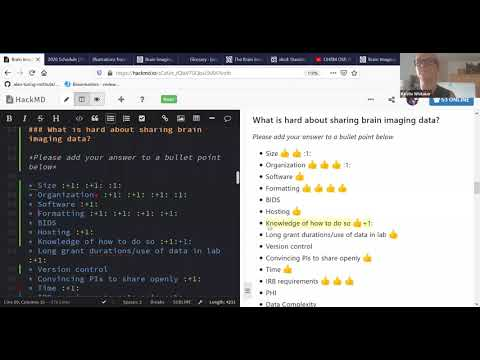

In [4]:
from IPython.display import YouTubeVideo
YouTubeVideo('XzfjxbTYQRM', start=1255, width=560, height=315)

## Caution! - Dummy scans

When we start acquiring fMRI data, scanner needs some time to reach a steady state. Therefore a common practice is to dicard the first couple of volumes - **the dummy scans** - from the functional acquisitions. Often it is done at the scanner level and we never see these scans. But sometimes we need to discard them ourselves. 

For the example dataset, used in this tutorial, we need to dicard the first two volumes from each functional run (2 dummy scans). 
You can exclude them either from the DICOM files before converting to BIDS or from the NIfTI files after BIDS conversion. As I took my DICOM files straight from the MRI server with read-only permissions, I excluded the dummy-scans after I converted the files to BIDS. 

To remove 2 dummy scans from each functional file in the dataset, I used the following generic bash script which uses `FSL` to remove the volumes:

**Example generic script** for removing dummy scans from a 4D NIfTI file: [code/dummies_script.sh](https://github.com/dcdace/fMRI_training/blob/main/code/dummies_script.sh)

The script in brief:

```bash
#!/bin/bash

file=$1
n_dummies=2

echo "Loading FSL"
module load fsl/6.0.1

temp_file="${file%.nii.gz}_temp.nii.gz"
echo "Creating temporary file $temp_file"

echo "Running fslroi with a temporary output file"
fslroi "$file" "$temp_file" $n_dummies -1

echo "Replacing the original file with the modified file"
mv "$temp_file" "$file"

echo "Done!"
```

To remove the dummy scans from all functional files in the dataset in parallel, I used this script. The script finds all functional files and runs the 'dummies_script.sh' for each file:

**Example script to remove dummy scans from all files in parallel**: [code/step04_remove_dummy_scans.sh](https://github.com/dcdace/fMRI_training/blob/main/code/step04_remove_dummy_scans.sh)

The script in brief:

```bash
#!/bin/bash

for run in ${BIDS_DIR}/sub-*/func/*.nii.gz; do
    sbatch \
        --job-name=dummies \
        "$SCRIPT_PATH" "$run"
done
```

## PyBIDS

`PyBids` is a Python module to interface with datasets conforming BIDS. See the [documentation](https://bids-standard.github.io/pybids/) and [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7409983/) for more info. 

```
pip install pybids
```

**Let's explore some of the functionality of pybids.layout.** The material is adapted from https://github.com/bids-standard/pybids/tree/master/examples

In [5]:
import os
from bids.layout import BIDSLayout

ds_path = '../data'

# Initialize the layout
layout = BIDSLayout(ds_path)

# Print some basic information about the layout
layout

BIDS Layout: ...ops/2024-CBU/notebooks/../data | Subjects: 16 | Sessions: 0 | Runs: 144

### Querying the BIDSLayout
The main method for querying `BIDSLayout` is `.get()`.

If we call `.get()` with no additional arguments, we get back a list of all the BIDS files in our dataset.

In [6]:
all_files = layout.get()
print("There are {} files in the layout.".format(len(all_files)))
print("\nThe first 5 files are:")
all_files[:5]

There are 583 files in the layout.

The first 5 files are:


[<BIDSFile filename='/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/CHANGES'>,
 <BIDSJSONFile filename='/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/dataset_description.json'>,
 <BIDSJSONFile filename='/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/participants.json'>,
 <BIDSDataFile filename='/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/participants.tsv'>,
 <BIDSFile filename='/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/README'>]

The returned object is a **Python list**. Each element in the list is a `BIDSFile` object. 

We can also get just filenames.

In [7]:
layout.get(return_type='filename')[:5]

['/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/CHANGES',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/dataset_description.json',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/participants.json',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/participants.tsv',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/README']

We can also get such information as
* all `subject` IDs
* all `task` names
* dataset `description`
* the BOLD repetition time TR
* how many `runs` there are

In [8]:
layout.get_subjects()

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16']

In [9]:
layout.get_tasks()

['facerecognition']

In [10]:
layout.get_dataset_description()

{'Acknowledgements': 'TODO: whom you want to acknowledge',
 'Authors': ['TODO:', 'First1 Last1', 'First2 Last2', '...'],
 'BIDSVersion': '1.8.0',
 'DatasetDOI': 'TODO: eventually a DOI for the dataset',
 'Funding': ['TODO', 'GRANT #1', 'GRANT #2'],
 'HowToAcknowledge': 'TODO: describe how to acknowledge -- either cite a corresponding paper, or just in acknowledgement section',
 'License': 'TODO: choose a license, e.g. PDDL (http://opendatacommons.org/licenses/pddl/)',
 'Name': 'TODO: name of the dataset',
 'ReferencesAndLinks': ['TODO', 'List of papers or websites']}

In [11]:
layout.get_tr()

2.0

Regarding runs, it might be that there are varied number of runs accross participants. So, let's get runs for each participant. 

In [12]:
for sID in layout.get_subjects(): 
    print(layout.get_runs(subject = sID))

[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]


### Filtering files by entities
We can pass any BIDS-defined entities (keywords) to `.get()` method. For example, here's how we would retrieve all BOLD runs with `.nii.gz` extensions for subject `04`.

In [13]:
# Retrieve filenames of all BOLD runs for subject
layout.get(subject='04', extension='nii.gz', suffix='bold', return_type='filename')

['/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-04/func/sub-04_task-facerecognition_run-01_bold.nii.gz',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-04/func/sub-04_task-facerecognition_run-02_bold.nii.gz',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-04/func/sub-04_task-facerecognition_run-03_bold.nii.gz',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-04/func/sub-04_task-facerecognition_run-04_bold.nii.gz',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-04/func/sub-04_task-facerecognition_run-05_bold.nii.gz',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-04/func/sub-04_task-facerecognition_run-06_bold.nii.gz',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-04/func/sub-04_task-facerecognition_run-07_bold.nii.gz',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-04/func/sub-04_task-facerecognition_run-08_bold.nii.gz',
 '/imaging/correia/da05/

All of the entities are found in the names of BIDS files. For example `sub-01_task-facerecognition_run-01_bold.nii.gz` has entities: **subject**, **task**, **run**, **suffix**, **extension**.

You can get the list of all availabe entities by `layout.get_entities()`.

Here are a few of the most common entities:

* `suffix`: The part of a BIDS filename just before the extension (e.g., 'bold', 'events', 'T1w', etc.).
* `subject`: The subject label
* `session`: The session label
* `run`: The run index
* `task`: The task name

### Filtering by metadata
Sometimes we want to search for files based not just on their names, but also based on metadata defined in JSON files. We can pass any key that occurs in any JSON file in our project as an argument to `.get()`. We can combine these with any number of core BIDS entities (like `subject`, `run`, etc.).

For example, we want to retrieve `SpacingBetweenSlices` (measured from center-to-center of each slice, in mm) for all our subjects. And let's create a nice data frame of this information.

In [14]:
import pandas as pd
d = []
for subject in layout.get_subjects():
    d.append(
        {
            'subject': subject,
            'spacing': layout.get_SpacingBetweenSlices(subject=subject, suffix='bold')
        }
    )
df = pd.DataFrame(d)

print(df.to_string(index=False))

subject spacing
     01  [3.75]
     02   [3.9]
     03   [3.9]
     04   [3.9]
     05  [3.75]
     06  [4.05]
     07  [3.75]
     08  [3.75]
     09  [3.75]
     10   [3.9]
     11  [3.75]
     12  [3.75]
     13   [3.9]
     14  [3.75]
     15   [3.9]
     16  [4.05]


Having different spacing between the slices is rather unusual. But authors were trying to cover the whole cortex. So, larger brains, had larger spacing.

**==================================================================================================**

**EXCERCISE**

We want to know the time of the day when each subject was scanned. The scanning started with T1 images, so we want to retrieve the `AcquisitionTime` of all subjects' `T1w` images. Adapt the script above to acquire this information. 


In [15]:
# write your code here


**==================================================================================================**

### Other `return_type` values
We can also ask `get()` to return unique values (or IDs) of particular entities. For example, we want to know which subjects had a fieldmap acquired. We can request that information by setting `return_type='id'` - to get subject IDs. When using this option, we also need to specify a `target` entity for the ID (in this case, subject). This combination tells the `BIDSLayout` to return the unique values for the specified `target` entity. 

For example, in the next example, we ask for all of the unique subject IDs that have at least one file with a `phasediff` (fieldmap) suffix. 

In [16]:
# Ask get() to return the ids of subjects that have phasediff (fieldmap_ files)

layout.get(return_type='id', target='subject', suffix='phasediff')

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16']

If our `target` is a BIDS entity that corresponds to a particular directory in the BIDS specification (e.g., `subject` or `session`) we can also use `return_type='dir'` to get all matching subdirectories. 

In [17]:
layout.get(return_type='dir', target='subject')

['/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-01',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-02',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-03',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-04',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-05',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-06',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-07',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-08',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-09',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-10',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-11',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-12',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-13',
 '/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-14',
 '/imaging/correia/d

### The `BIDSFile`
When you call `.get()` on a `BIDSLayout`, the default returned values are objects of class `BIDSFile`. A `BIDSFile` is a lightweight container for individual files in a BIDS dataset. It provides easy access to a variety of useful attributes and methods. Let's take a closer look. First, let's pick a random file from our existing `layout`.

In [18]:
# Pick the 7th file in the dataset
bf = layout.get()[7]
# Print it
bf

<BIDSImageFile filename='/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-01/anat/sub-01_T1w.nii.gz'>

Here are some of the attributes and methods available to us in a `BIDSFile` (note that some of these are only available for certain subclasses of `BIDSFile`; e.g., you can't call `get_image()` on a `BIDSFile` that doesn't correspond to an image file!):
* `.path`: The full path of the associated file
* `.filename`: The associated file's filename (without directory)
* `.dirname`: The directory containing the file
* `.get_entities()`: Returns information about entities associated with this `BIDSFile` (optionally including metadata)
* `.get_image()`: Returns the file contents as a nibabel image (only works for image files)
* `.get_df()`: Get file contents as a pandas DataFrame (only works for TSV files)
* `.get_metadata()`: Returns a dictionary of all metadata found in associated JSON files
* `.get_associations()`: Returns a list of all files associated with this one in some way

Let's see some of these in action.

In [19]:
# Print all the entities associated with this file, and their values
bf.get_entities()

{'datatype': 'anat', 'extension': '.nii.gz', 'subject': '01', 'suffix': 'T1w'}

In [20]:
# Print first 30 metadata items associated with this file
file_metadata = bf.get_metadata()

{k: file_metadata[k] for k in list(file_metadata)[:30]}

{'AcquisitionMatrixPE': 246,
 'AcquisitionNumber': 1,
 'AcquisitionTime': '16:43:32.335000',
 'BaseResolution': 256,
 'CoilCombinationMethod': 'Adaptive Combine',
 'CoilString': 'T:HEA;HEP',
 'ConversionSoftware': 'dcm2niix',
 'ConversionSoftwareVersion': 'v1.0.20230411',
 'DeviceSerialNumber': '35119',
 'DwellTime': 8.5e-06,
 'EchoTime': 0.00298,
 'FlipAngle': 9,
 'HeudiconvVersion': '1.0.1',
 'ImageComments': 'V',
 'ImageOrientationPatientDICOM': [0, 1, 0, 0, 0, -1],
 'ImageOrientationText': 'Sag',
 'ImageType': ['ORIGINAL', 'PRIMARY', 'M', 'ND', 'NORM'],
 'ImagingFrequency': 123.251801,
 'InPlanePhaseEncodingDirectionDICOM': 'ROW',
 'InstitutionAddress': 'Chaucer Road  15,Cambridge,UK,GB,CB2 2EF',
 'InstitutionName': 'MRC-CBU',
 'InversionTime': 0.9,
 'MRAcquisitionType': '3D',
 'MagneticFieldStrength': 3,
 'Manufacturer': 'Siemens',
 'ManufacturersModelName': 'TrioTim',
 'MatrixCoilMode': 'GRAPPA',
 'Modality': 'MR',
 'NonlinearGradientCorrection': False,
 'ParallelReductionFactorI

`.get_image()`: Returns the file contents as a `nibabel` image (only works for image files). We can then display the image, for example, using `OrthoSlicer3D`.   

**Note:** When using `orthoview()` in notebook, don't forget to close figures afterward again or use %matplotlib inline again, otherwise, you cannot plot any other figures.

<OrthoSlicer3D: /imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-01/anat/sub-01_T1w.nii.gz (192, 256, 256)>

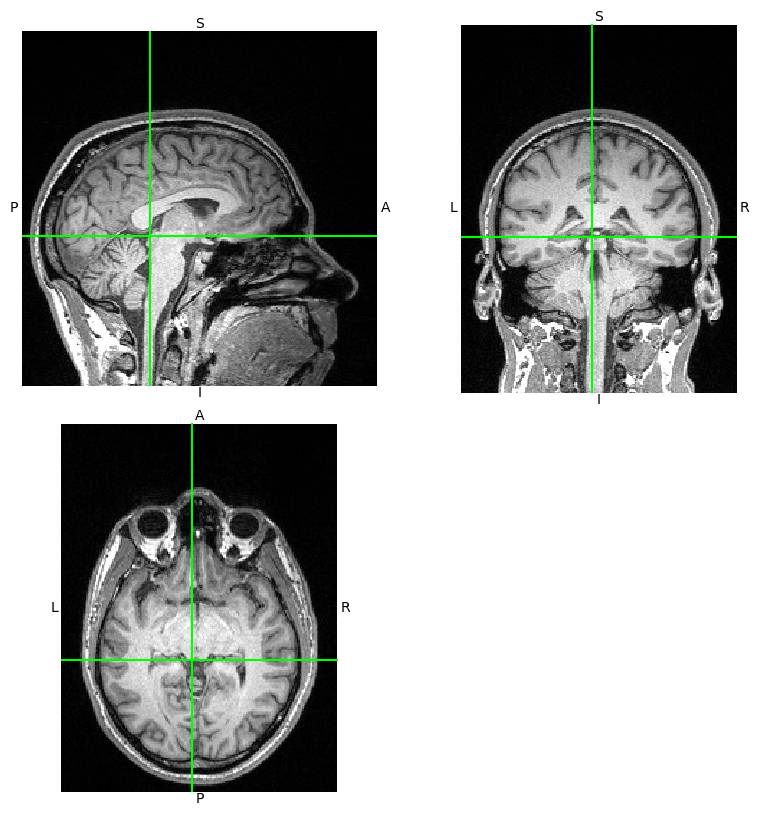

In [31]:
%matplotlib inline

bf.get_image().orthoview()

### `.tsv` files

In cases where a file has a `.tsv.gz` or `.tsv` extension, it will automatically be created as a `BIDSDataFile`, and we can easily grab the contents as a `DataFrame`.

Let's look at the first `events` file from our layout.

In [22]:
# Get the first events file
evfile = layout.get(suffix='events')[0]

# Get contents as a DataFrame and show the first few rows
df = evfile.get_df()
df.head()

,onset,duration,circle_duration,trial_type,trigger,button_pushed,response_time,stim_file
0,0.000,0.908,0.534,FAMOUS,5,4.0,2.158,func/f013.bmp
1,3.273,0.962,0.586,FAMOUS,6,4.0,1.233,func/f013.bmp
2,6.647,0.825,0.546,UNFAMILIAR,13,4.0,1.183,func/u014.bmp
3,9.838,0.968,0.597,UNFAMILIAR,14,4.0,0.930,func/u014.bmp
4,12.978,0.904,0.415,UNFAMILIAR,13,7.0,1.068,func/u016.bmp


Let's look at the `participants` information. 

In [23]:
participants = layout.get(suffix='participants', extension='tsv')[0]

df = participants.get_df()
df.sort_values(by=['participant_id'])

,participant_id,age,sex,group
1,sub-01,31,M,control
3,sub-02,25,M,control
2,sub-03,30,M,control
0,sub-04,26,F,control
10,sub-05,23,F,control
4,sub-06,26,M,control
11,sub-07,31,F,control
14,sub-08,26,M,control
7,sub-09,29,M,control
15,sub-10,23,M,control


### Filename parsing
Let's say you have a filename, and you want to manually extract BIDS entities from it. The `parse_file_entities` method provides the facility:

In [24]:
layout.parse_file_entities('some_path_to_bids_file/sub-04_task-facerecognition_run-01_bold.nii.gz')

{'subject': '04',
 'task': 'facerecognition',
 'run': 01,
 'suffix': 'bold',
 'extension': '.nii.gz'}

You can do the same for `BIDSFile` object that we defined earlier. 

In [25]:
layout.parse_file_entities(bf.path)

{'subject': '01', 'suffix': 'T1w', 'datatype': 'anat', 'extension': '.nii.gz'}

In [26]:
layout.parse_file_entities(bf.filename)

{'suffix': 'T1w', 'extension': '.nii.gz'}

### Path construction
You may want to create valid BIDS filenames for new files that would sit within your BIDS project. This is useful when you know what entity values you need to write out to, but don’t want to deal with looking up the precise BIDS file-naming syntax. All we need to do is define a dictionary with the name components, and build_path takes care of the rest (including injecting sub-directories):

In [27]:
entities = {
    'subject': '01',
    'run': '02',
    'task': 'facerecognition',
    'suffix': 'bold'
}

layout.build_path(entities)

'/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-01/func/sub-01_task-facerecognition_run-02_bold.nii.gz'

Keep in mind that `_` and `-` have special meaning in BIDS specification. E.g., you can't name your task `face-recognition`, that would not be 'spec-compliant' and would end in an error! However, if you add `validate=False`, you can get away with it (i'e', `layout.build_path(entities, validate=False)`). 

You can also use `build_path` in more sophisticated ways by defining your own set of matching templates that cover cases not supported by BIDS out of the box. For example, suppose you want to create a template for naming a new `stat` file (containig statistical results of your rMRI analysis). You could do something like:

In [28]:
# Define the pattern to build out of the components passed in the dictionary
pattern = "sub-{subject}_task-{task}_run-{run}_type-{type}_{suffix}.nii.gz"

entities = {
    'subject': '01',
    'task': 'facerecognition',
    'run': '02',
    'type': 'tval',
    'suffix': 'stat'
}

# Notice we pass the new pattern as the second argument
layout.build_path(entities, pattern, validate=False)

'/imaging/correia/da05/workshops/2024-CBU/notebooks/../data/sub-01_task-facerecognition_run-02_type-tval_stat.nii.gz'

### Report generation
`PyBIDS` also allows you to automatically create data acquisition reports based on the available `image` and `meta-data` information. This enables a new level of standardisation and transparency. FAIR-ness, meta-analyses, etc. 

In [29]:
# import the BIDSReport function from the reports submodule
from bids.reports import BIDSReport

Now we only need to apply the `BIDSReport` function to our `layout` and generate our report. 

In [30]:
# Initialize a report for the dataset
report = BIDSReport(layout)

# Method generate returns a Counter of unique descriptions across subjects
try:
    descriptions = report.generate()
    pub_description = descriptions.most_common()[0][0]
    print(pub_description)
except IndexError:
    print('Sorry, it seems that the dataset is not complete and report cannot be generated.')

/home/da05/.conda/envs/fmri/lib/python3.12/site-packages/bids/reports/parsing.py:386: UserWarning: sub-01_acq-func_magnitude1.nii.gz not yet supported.
  warnings.warn(group[0].filename + " not yet supported.")
/home/da05/.conda/envs/fmri/lib/python3.12/site-packages/bids/reports/parsing.py:386: UserWarning: sub-01_acq-func_magnitude2.nii.gz not yet supported.
  warnings.warn(group[0].filename + " not yet supported.")
/home/da05/.conda/envs/fmri/lib/python3.12/site-packages/bids/layout/models.py:229: UserWarning: Accessing entities as attributes is deprecated as of 0.7. Please use the .entities dictionary instead (i.e., .entities['run'] instead of .run.
  warnings.warn("Accessing entities as attributes is deprecated as "
/home/da05/.conda/envs/fmri/lib/python3.12/site-packages/bids/reports/parsing.py:386: UserWarning: sub-02_acq-func_magnitude1.nii.gz not yet supported.
  warnings.warn(group[0].filename + " not yet supported.")
/home/da05/.conda/envs/fmri/lib/python3.12/site-packages/b

Number of patterns detected: 6
Remember to double-check everything and to replace <deg> with a degree symbol.
In session None, MR data were acquired using a 3-Tesla Siemens TrioTim MRI scanner.
	One run of T1-weighted SP\MP\OSP GR\IR (GR\IR) single-echo structural MRI data were collected (256 slices; repetition time, TR=2250ms; echo time, TE=2.98ms; flip angle, FA=9<deg>; field of view, FOV=192x256mm; matrix size=192x256; voxel size=1x1x1mm).
	A spoiled gradient recalled (GR) field map (phase encoding: anterior to posterior; 33 slices in interleaved ascending order; repetition time, TR=400ms; echo time 1 / 2, TE1/2=5.197.65ms; flip angle, FA=60<deg>; field of view, FOV=192x192mm; matrix size=64x64; voxel size=3x3x3.75mm) was acquired for the first, second, third, fourth, fifth, sixth, seventh, eighth, and ninth runs of the facerecognition BOLD scan.
	Nine runs of facerecognition segmented k-space echo planar (EP) single-echo fMRI data were collected (33 slices in interleaved ascending 

/home/da05/.conda/envs/fmri/lib/python3.12/site-packages/bids/reports/parsing.py:386: UserWarning: sub-16_acq-func_magnitude1.nii.gz not yet supported.
  warnings.warn(group[0].filename + " not yet supported.")
/home/da05/.conda/envs/fmri/lib/python3.12/site-packages/bids/reports/parsing.py:386: UserWarning: sub-16_acq-func_magnitude2.nii.gz not yet supported.
  warnings.warn(group[0].filename + " not yet supported.")


**Can you spot an error in the report?**